In [1]:
import pandas as pd


In [2]:
df = pd.read_csv(filepath_or_buffer='data/drug200.csv')
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


In [3]:
df.shape

(200, 6)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [ ]:
# Aykırı değerleri saptayalım
for column in df.columns:
    print(f'Column Name: {column}\n'
          f'Outlier Values: {df[column].nunique()}\n'
          f'======================================='
    )

Column Name: Age
Outlier Values: 57
Column Name: Sex
Outlier Values: 2
Column Name: BP
Outlier Values: 3
Column Name: Cholesterol
Outlier Values: 2
Column Name: Na_to_K
Outlier Values: 198
Column Name: Drug
Outlier Values: 5


In [23]:
from sklearn.preprocessing import LabelEncoder

df['Sex'] = LabelEncoder().fit(df['Sex'].unique()).transform(df['Sex'])
df['BP'] = LabelEncoder().fit(df['BP'].unique()).transform(df['BP'])
df['Cholesterol'] = LabelEncoder().fit(df['Cholesterol'].unique()).transform(df['Cholesterol'])


In [24]:
df.columns

Index(['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K', 'Drug'], dtype='object')

In [25]:
# Decision tree bir sınıflama algoritması olmasından ötürü KNN olduğu gibi features matrix oluşturalım
X = df[['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K']].values

#y ise sınıfların oluşacağı target feature oluşturalım

y=df[['Drug']].values

In [26]:
# X değişkeni tipi ndarray olduğundan dolayı head() fonksiyonu yerine dilimleme kullandık
X[:5]

array([[23.   ,  0.   ,  0.   ,  0.   , 25.355],
       [47.   ,  1.   ,  1.   ,  0.   , 13.093],
       [47.   ,  1.   ,  1.   ,  0.   , 10.114],
       [28.   ,  0.   ,  2.   ,  0.   ,  7.798],
       [61.   ,  0.   ,  1.   ,  0.   , 18.043]])

In [27]:
y[:5]

array([['drugY'],
       ['drugC'],
       ['drugC'],
       ['drugX'],
       ['drugY']], dtype=object)

In [28]:
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)
X[:5]

array([[-1.29159102, -1.040833  , -1.11016894, -0.97043679,  1.28652212],
       [ 0.16269866,  0.96076892,  0.10979693, -0.97043679, -0.4151454 ],
       [ 0.16269866,  0.96076892,  0.10979693, -0.97043679, -0.82855818],
       [-0.988614  , -1.040833  ,  1.32976279, -0.97043679, -1.14996267],
       [ 1.0110343 , -1.040833  ,  0.10979693, -0.97043679,  0.27179427]])

In [33]:
# Split Data Set

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size = 0.2, random_state=42)

In [45]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=3,
    random_state=42
)

decision_tree = decision_tree.fit(X_train, y_train)

decision_tree.tree_.node_count, decision_tree.tree_.max_depth

(9, 3)

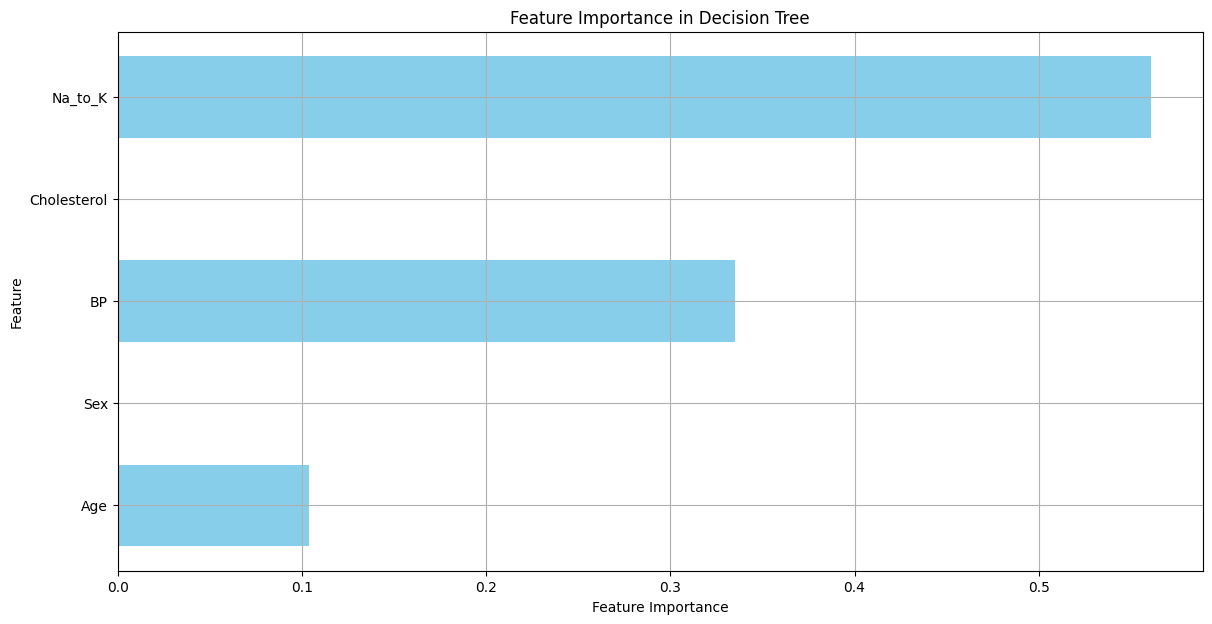

In [59]:
# Start node belirleme
from matplotlib.pylab import plt

importance = decision_tree.feature_importances_
features_names = ['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K']

plt.figure(
    figsize=(14,7),
)
plt.barh(
    features_names, importance, color='skyblue'
)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Decision Tree')
plt.grid()
plt.show()

In [49]:
# Detect of Maximum Depth

from sklearn.model_selection import GridSearchCV

GridSearch = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid={
        'max_depth': range(1, decision_tree.tree_.max_depth + 1, 2),
        'max_features': range(1, len(decision_tree.feature_importances_)+1)        
    },
    scoring='accuracy',
    n_jobs=-1
)

GridSearch = GridSearch.fit(X_train, y_train)

print(f'Bulunan Node Sayısı: {GridSearch.best_estimator_.tree_.node_count}\n'
      f'Maksimum Derinlik: {GridSearch.best_estimator_.tree_.max_depth}')

Bulunan Node Sayısı: 9
Maksimum Derinlik: 3


In [52]:
# Modelin doğruluğunu ölçelim

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def measure_errors(y_true, y_pred, dataset_name) ->pd.DataFrame:
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    return pd.DataFrame(
        {
            dataset_name: [acc, precision, recall, f1]
        },
        index=['Accuracy', 'Precision', 'Recall', 'F1 Score']
    )



In [53]:
y_train_pred = decision_tree.predict(X_train)
y_test_pred = decision_tree.predict(X_test)

train_test_full_error_df = pd.concat(
    [
        measure_errors(y_train, y_train_pred, 'train'),
        measure_errors(y_test, y_test_pred, 'test')
    ],
    axis = 1
)

train_test_full_error_df

,train,test
Accuracy,0.931250,0.875000
Precision,0.759259,0.737500
Recall,0.800000,0.800000
F1 Score,0.777320,0.762963


In [54]:
# Grid Search Sonucunda Elde Ettiğimiz sonuçları test edelim

y_train_pred_gr = GridSearch.predict(X_train)
y_test_pred_gr = GridSearch.predict(X_test)

gr_error_df = pd.concat(
    [
        measure_errors(y_train, y_train_pred_gr, 'train'),
        measure_errors(y_test, y_test_pred_gr, 'test')
    ],
    axis=1
)

gr_error_df

,train,test
Accuracy,0.931250,0.875000
Precision,0.759259,0.737500
Recall,0.800000,0.800000
F1 Score,0.777320,0.762963


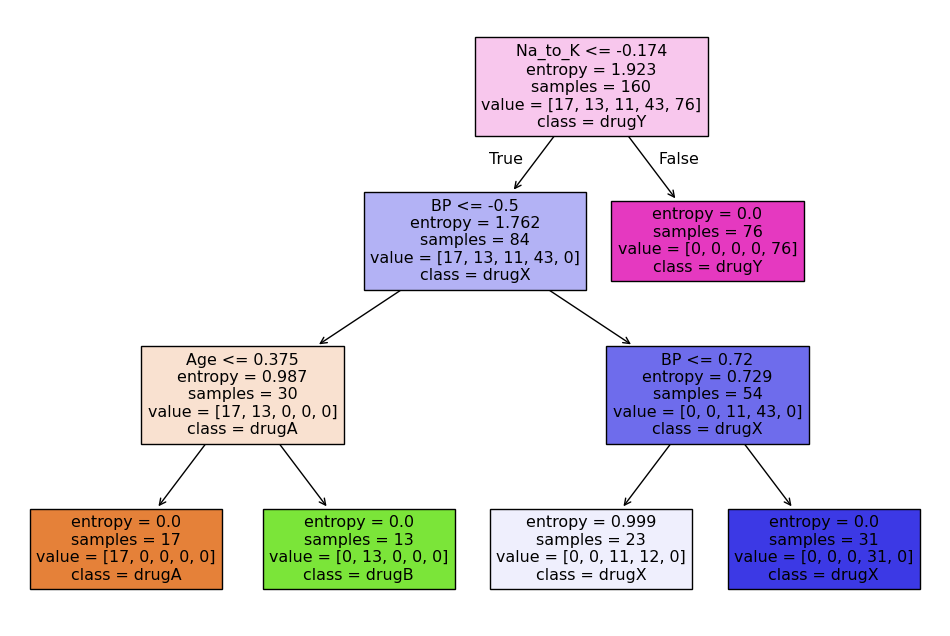

In [60]:
from sklearn import tree
import numpy as np

plt.figure(figsize=(12,8))
tree.plot_tree(
    decision_tree= decision_tree,
    feature_names=features_names,
    class_names=np.unique(y_train),
    filled=True
)
plt.show()